<a href="https://colab.research.google.com/github/bayuuat/Bangkit-CAP0451-ML/blob/master/Bangkit_peasant_model_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Getting dataset
Download and extract

In [ ]:
#!pip install pyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({"id":"1mJES4K0DYs_6vHTJvD1lfC4rihSlcKgv"})
downloaded.GetContentFile("peasant.zip")


In [2]:
import zipfile
zip = "peasant.zip"
zip_ref = zipfile.ZipFile(zip, 'r')
zip_ref.extractall()
zip_ref.close()

#Preparing the dataset
train, valid, test

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = "peasant/training"
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=32, target_size=(224, 224), class_mode="categorical"
)

valid_dir = "peasant/validation"
valid_datagen = ImageDataGenerator(rescale=1.0 / 255)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, batch_size=32, target_size=(224, 224), class_mode="categorical"
)

test_dir = "peasant/testing"
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir, batch_size=32, target_size=(224, 224), class_mode="categorical"
)

#Defining the model

##Using baseline model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.normalization.BatchNormalization(input_shape=(250, 250, 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(train_generator.class_indices.keys()),
                          activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(train_generator,
                    epochs=100,
                    steps_per_epoch=50,
                    validation_data = valid_generator,
                    verbose = 1)

##Using Xception

In [ ]:
from tensorflow.keras.applications.xception import Xception

model = Xception(weights='imagenet',
                      input_shape = (250,250,3),
                      include_top=False,
                      pooling = 'avg')


In [ ]:
x = model.output
x = tf.keras.layers.Dense(256, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices.keys()),
                    activation='softmax')(x)

model = tf.keras.Model(inputs=model.input, outputs=predictions)

for layer in model.layers:
    layer.trainable = False

opt = tf.keras.optimizers.Adam(lr=0.001,
                               decay = 1e-6,
                               beta_1=0.9,
                               beta_2=0.999,
                               amsgrad=False)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

In [ ]:
history = model.fit(train_generator,
          epochs=4,
          validation_data=valid_generator,
          verbose = 1)

##Using Imagenet

In [ ]:
import tensorflow_hub as hub

feature_extractor = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                                   input_shape=(224,224,3,), 
                                   output_shape=[1280],
                                   trainable= False)

In [ ]:
model = tf.keras.models.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(len(train_generator.class_indices.keys()),
                              activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(train_generator,
                    epochs=5,
                    validation_data=valid_generator)

##Using vgg16

In [111]:
model = tf.keras.applications.vgg16.VGG16(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet')

for layer in model.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
x = tf.keras.layers.Flatten()(model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)                  
x = tf.keras.layers.Dense(len(train_generator.class_indices.keys()),
                 activation='softmax')(x)           

model = tf.keras.Model(model.input, x) 

model.compile(tf.keras.optimizers.Adam(), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model.summary()

In [ ]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 20,
    verbose = 2
)

#Plotting Training and Validation
accuracy and loss

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

#Predicting

Saving CornCommonRust3.JPG to CornCommonRust3.JPG
Corn_Common_rust 1.0


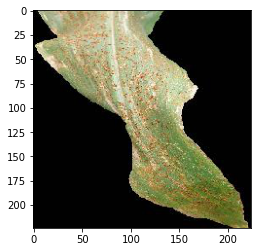

In [145]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
uploaded = files.upload()
labels = list(train_generator.class_indices.keys())
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = tf.expand_dims(x, axis=0)
  pred = model.predict(x)
  print(labels[tf.argmax(pred[0])], pred.max())

  plt.imshow(img)
  plt.show()

#Saving Model

In [ ]:
name_version = "version2"
model.save(name_version)
model.save("{}/{}.h5".format(name_version, name_version))

In [137]:
!zip -r version2.zip version2

  adding: version2/ (stored 0%)
  adding: version2/version2.h5 (deflated 34%)
  adding: version2/saved_model.pb (deflated 91%)
  adding: version2/variables/ (stored 0%)
  adding: version2/variables/variables.data-00000-of-00001 (deflated 34%)
  adding: version2/variables/variables.index (deflated 67%)
  adding: version2/keras_metadata.pb (deflated 95%)
  adding: version2/assets/ (stored 0%)
